# Deep Convolutional GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. DCGAN is explained in chapter 8 of [Deep Learning for Vision Systems](https://www.manning.com/books/deep-learning-for-vision-systems) book. The DCGAN architecture was first explored in 2016 by Alec Radford et al. and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset. Fashion MNIST dataset consists of 60,000 grayscale images for training and a test set of 10,000 images. Each image is a 28x28 grayscale image, associated with a label from 10 classes. Fashion-MNIST is inteded to serve as a direct replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.



![Fashion MNIST examples](assets/fashion-mnist.png)

In [1]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
%matplotlib inline

from keras.datasets import fashion_mnist

from tqdm import tqdm
from PIL import Image
import numpy as np
import os

### Download and visualize the dataset

In [2]:
def load_imgs(impath):
    imgs=[]
    label=[]
    l1=os.listdir(impath)
    for i in l1[:2]:
        img=Image.open(impath+i)
        img=img.resize(size=(28,28))
        #img=img.convert('L')
        #img=np.array(img,dtype=np.float16)/255
        imgs.append(np.array(img)) #.flatten())
        label.append(i)
        del img
        #c=c+1

        '''if(c%1000==0):
            plt.imshow(img)
            plt.show()
            c=c+1'''
    return np.array(imgs),label


In [3]:
training_data,x_label=load_imgs('/kaggle/input/flowers-imitation/flowers_imitation/')
training_data.shape,len(x_label)

((2, 28, 28, 3), 2)

# Load the dataset
(training_data, _), (_, _) = fashion_mnist.load_data()

def visualize_input(img, ax):
    ax.imshow(img, cmap='gray')
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img[x][y],2)), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y]<thresh else 'black')

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
visualize_input(training_data[3343], ax)

In [4]:
# Rescale the training data to scale -1 to 1
X_train = training_data / 127.5 - 1.
#X_train = np.expand_dims(X_train, axis=3)

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our Fashion MNIST dataset, we only want it to be 28x28x1.

In [5]:
def build_generator():

    model = Sequential()

    model.add(Dense(128 * 7 * 7, activation="relu", input_dim= latent_dim))
    model.add(Reshape((7, 7, 128)))
    model.add(UpSampling2D())

    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())

    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(Conv2D(channels, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))

    model.summary()

    noise = Input(shape=(latent_dim,))
    img = model(noise)

    return Model(noise, img)


## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've build before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU. 

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

In [6]:
def build_discriminator():

    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape= img_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    model.summary()

    img = Input(shape= img_shape)
    validity = model(img)

    return Model(img, validity)

In [7]:
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, latent_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28, 3)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

In [8]:
# Input shape
img_shape = (28,28,3)
channels = 3
latent_dim = 100

optimizer = Adam(0.0002, 0.5)

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Build the generator
generator = build_generator()

# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

2022-12-23 12:25:35.383812: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-23 12:25:35.384792: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-23 12:25:35.741287: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-23 12:25:35.742285: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-23 12:25:35.743130: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 64)          0

In [9]:
X_train.shape

(2, 28, 28, 3)

In [10]:
def train(epochs, batch_size=128, save_interval=50):

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        #print(imgs.shape)
        # Sample noise and generate a batch of new images
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_imgs = generator.predict(noise)

        # Train the discriminator (real classified as ones and generated as zeros)
        d_loss_real = discriminator.train_on_batch(imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        #print(d_loss_real.__str__)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        #d_loss=0.0
        # ---------------------
        #  Train Generator
        # ---------------------

        # Train the generator (wants discriminator to mistake images as real)
        g_loss = combined.train_on_batch(noise, valid)

        # Plot the progress
        if epoch%100 == 0 :
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            plot_generated_images(epoch, generator)

2022-12-23 12:25:41.946148: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-23 12:25:45.845177: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


0 [D loss: 1.023868, acc.: 35.94%] [G loss: 0.672893]
100 [D loss: 0.022060, acc.: 100.00%] [G loss: 4.687640]


2022-12-23 12:26:11.247315: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


200 [D loss: 0.001569, acc.: 100.00%] [G loss: 2.640511]
300 [D loss: 0.008194, acc.: 100.00%] [G loss: 0.284846]


2022-12-23 12:26:25.279618: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


400 [D loss: 0.000321, acc.: 100.00%] [G loss: 0.208862]
500 [D loss: 0.000077, acc.: 100.00%] [G loss: 0.203911]


2022-12-23 12:26:42.399383: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-12-23 12:26:42.519590: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


600 [D loss: 0.000038, acc.: 100.00%] [G loss: 0.110285]
700 [D loss: 0.000082, acc.: 100.00%] [G loss: 0.107403]


2022-12-23 12:26:58.142971: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-12-23 12:26:58.654928: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


800 [D loss: 0.000050, acc.: 100.00%] [G loss: 0.085317]
900 [D loss: 0.000127, acc.: 100.00%] [G loss: 0.110428]
1000 [D loss: 0.000194, acc.: 100.00%] [G loss: 0.117431]
1100 [D loss: 0.000015, acc.: 100.00%] [G loss: 0.008544]
1200 [D loss: 0.000018, acc.: 100.00%] [G loss: 0.092538]
1300 [D loss: 0.000025, acc.: 100.00%] [G loss: 0.050373]


2022-12-23 12:27:46.085952: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


1400 [D loss: 0.000012, acc.: 100.00%] [G loss: 0.037146]
1500 [D loss: 0.000029, acc.: 100.00%] [G loss: 0.001817]
1600 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.005627]
1700 [D loss: 0.000007, acc.: 100.00%] [G loss: 0.008202]


2022-12-23 12:28:17.187120: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


1800 [D loss: 0.000055, acc.: 100.00%] [G loss: 0.143988]
1900 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.016523]
2000 [D loss: 0.000006, acc.: 100.00%] [G loss: 0.035962]
2100 [D loss: 0.000009, acc.: 100.00%] [G loss: 0.012022]
2200 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.002799]
2300 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.031754]
2400 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.004735]
2500 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.020153]
2600 [D loss: 0.000006, acc.: 100.00%] [G loss: 0.008502]
2700 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.008065]
2800 [D loss: 0.000001, acc.: 100.00%] [G loss: 0.002306]


2022-12-23 12:29:43.593950: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2900 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.002297]


2022-12-23 12:29:52.299749: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


3000 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.004679]
3100 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.003213]
3200 [D loss: 0.000001, acc.: 100.00%] [G loss: 0.008781]
3300 [D loss: 0.000001, acc.: 100.00%] [G loss: 0.008765]


2022-12-23 12:30:24.047430: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-12-23 12:30:24.159783: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


3400 [D loss: 0.000001, acc.: 100.00%] [G loss: 0.002324]
3500 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.005228]
3600 [D loss: 0.000001, acc.: 100.00%] [G loss: 0.004173]
3700 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.010815]


2022-12-23 12:30:54.720631: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-12-23 12:30:54.739161: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-12-23 12:30:55.187287: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


3800 [D loss: 0.000001, acc.: 100.00%] [G loss: 0.001322]


2022-12-23 12:31:00.501214: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


3900 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.002157]


2022-12-23 12:31:11.545612: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


4000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.001771]
4100 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.008253]
4200 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.006656]
4300 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.001648]


2022-12-23 12:31:44.394622: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


4400 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.001422]
4500 [D loss: 0.000001, acc.: 100.00%] [G loss: 0.001651]
4600 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000384]


2022-12-23 12:32:06.268661: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


4700 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.001636]
4800 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.010401]
4900 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.002700]


2022-12-23 12:32:29.659170: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


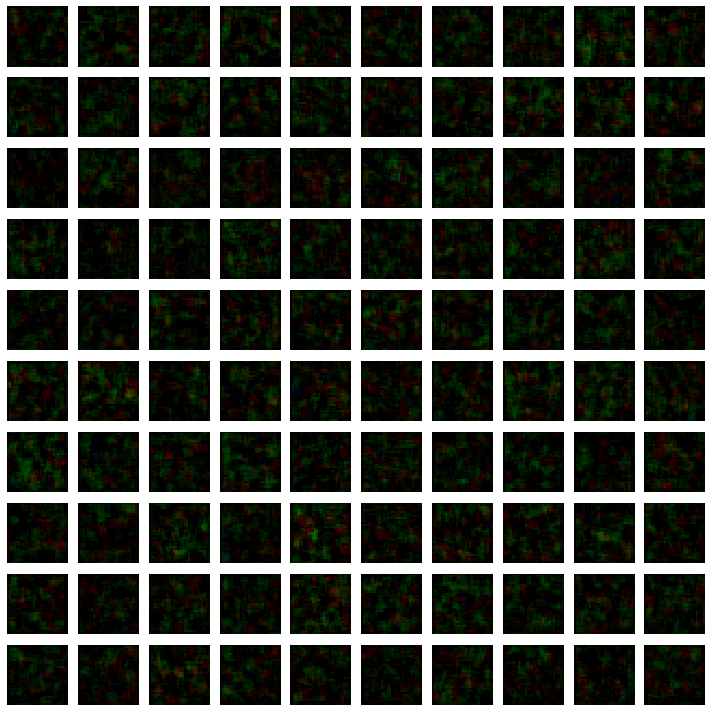

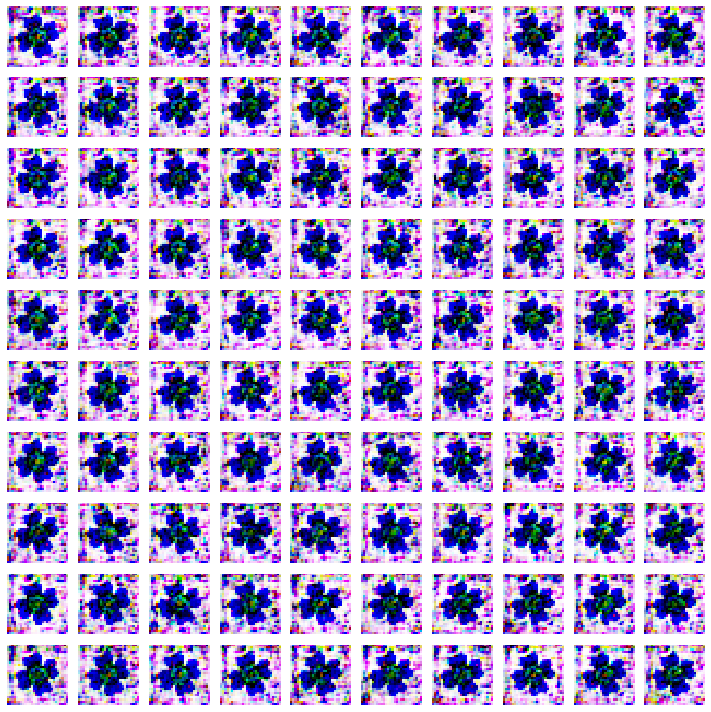

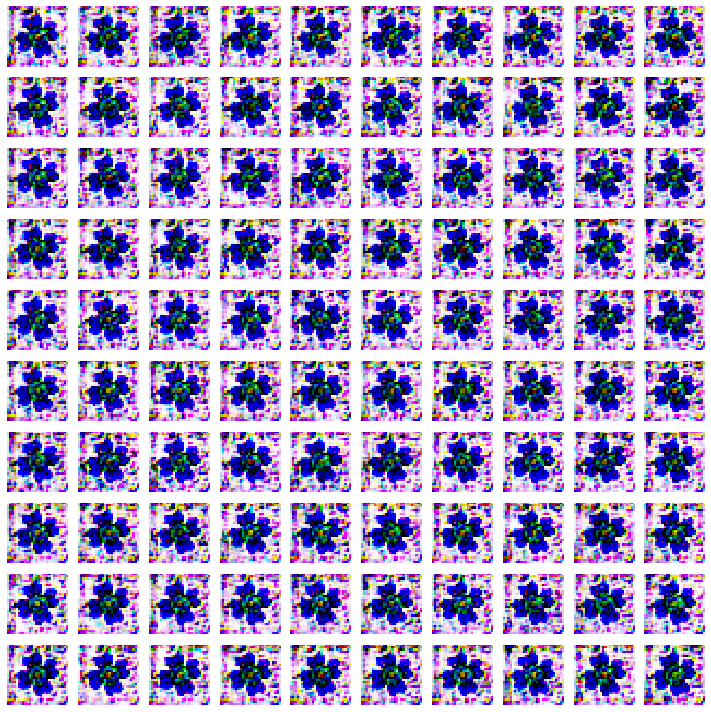

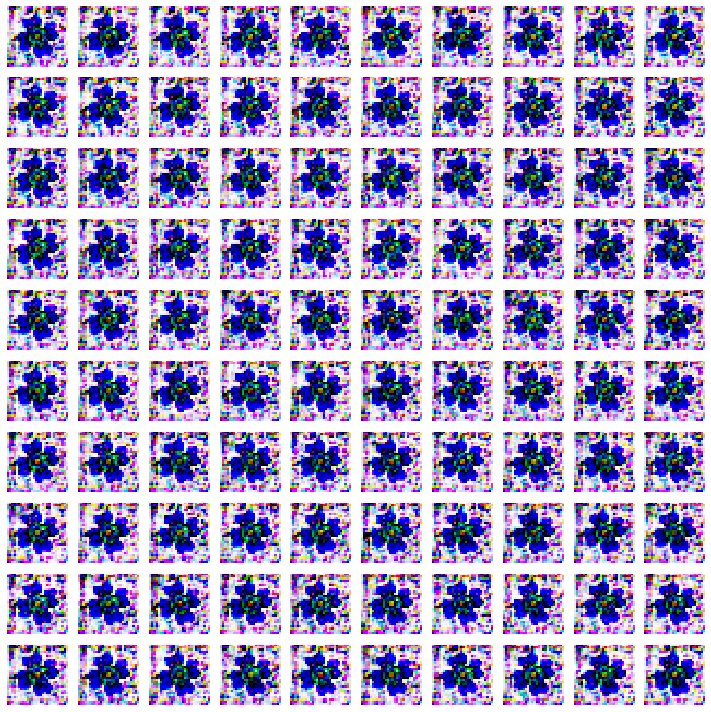

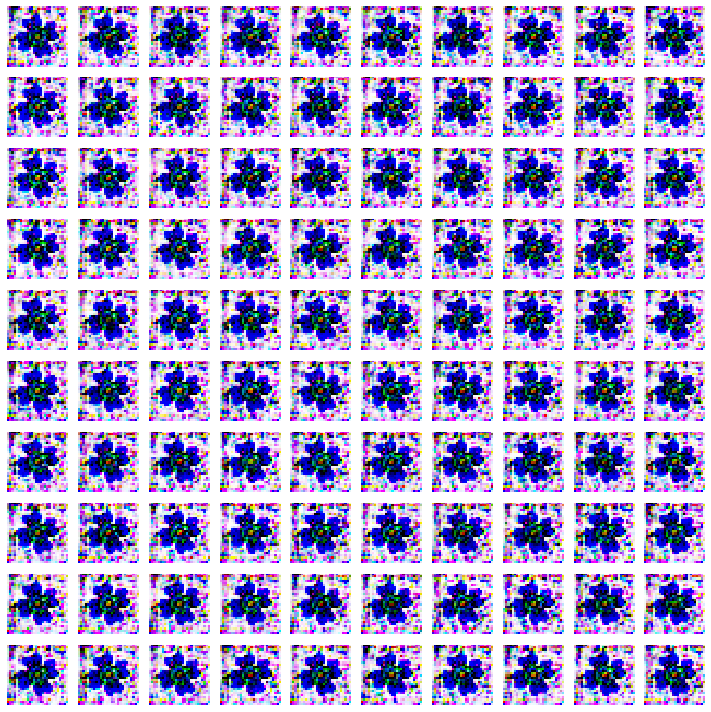

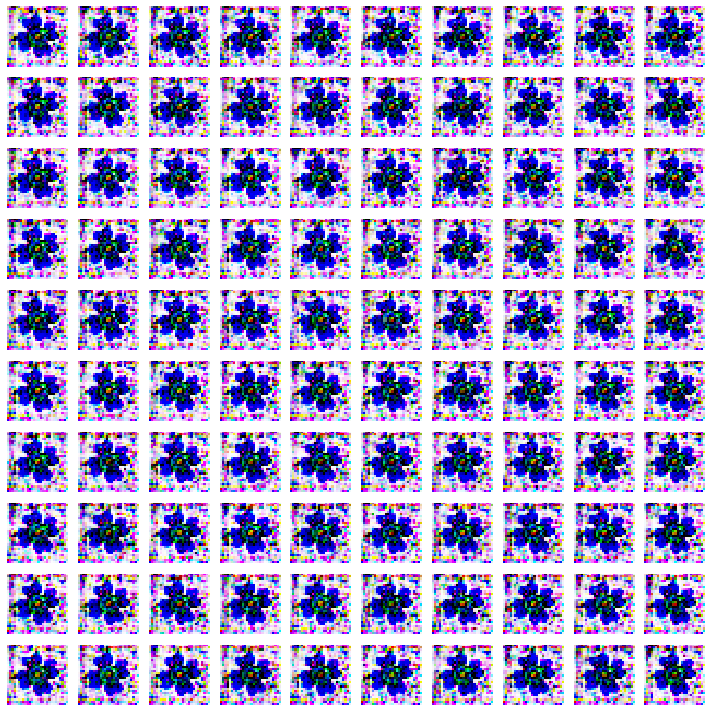

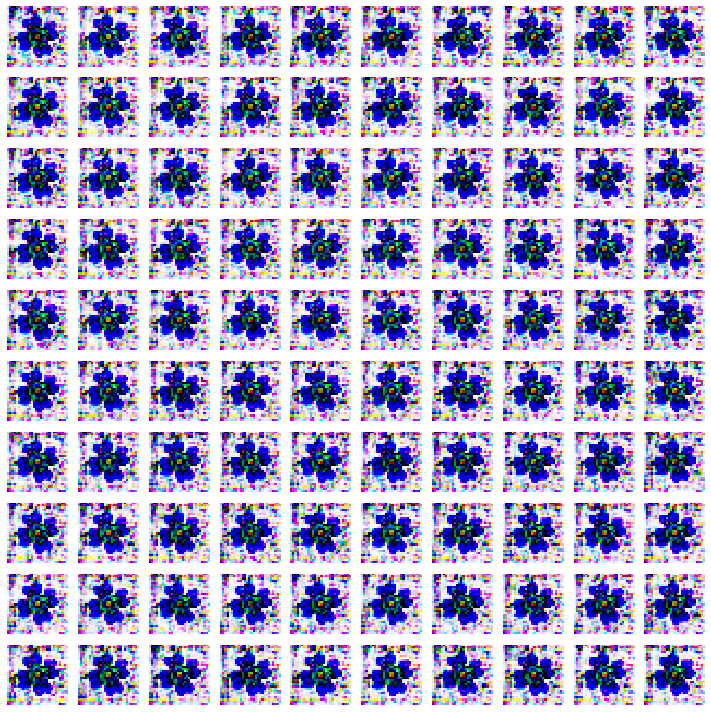

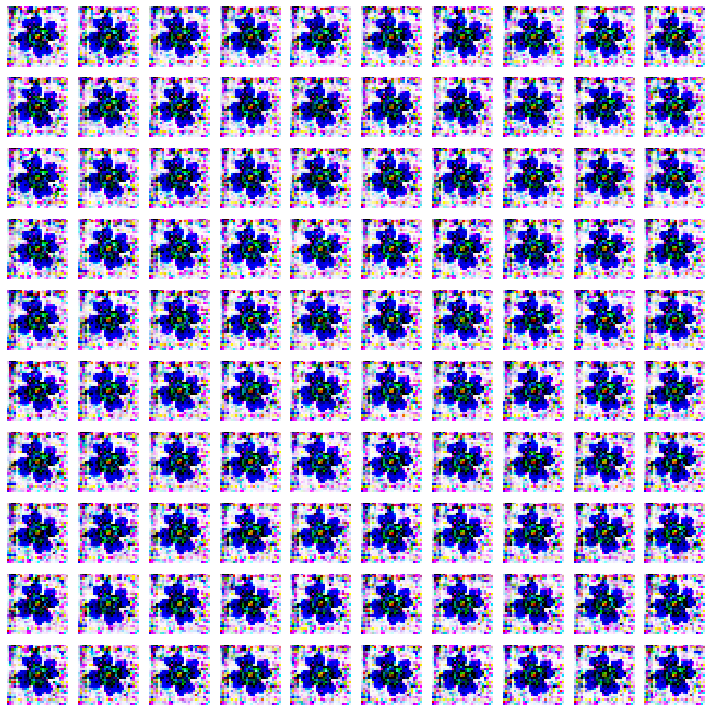

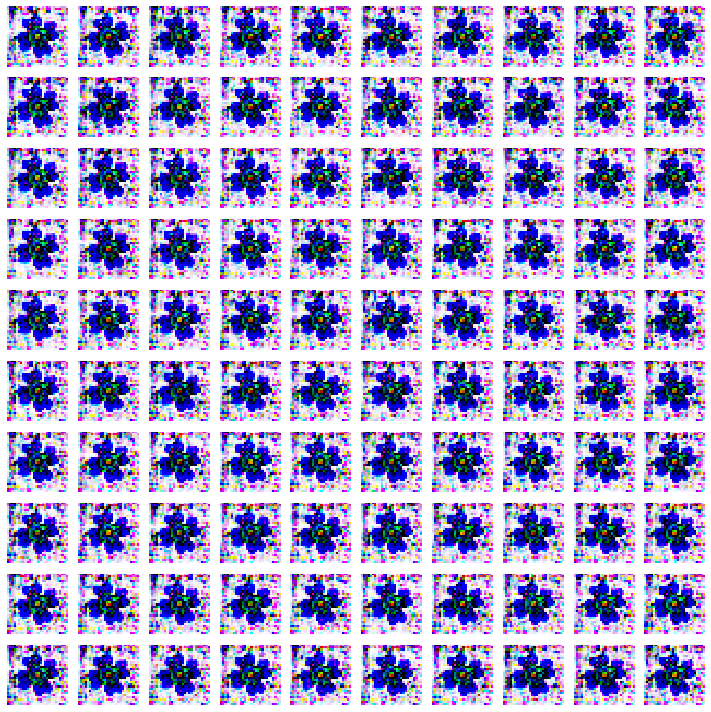

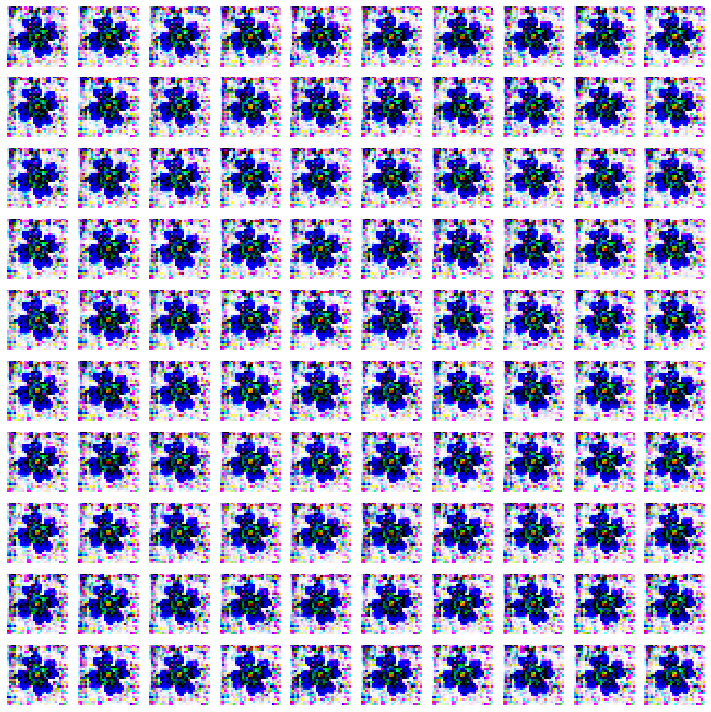

In [11]:
train(epochs=5000, batch_size=32, save_interval=500)

# The End